<a href="https://colab.research.google.com/github/leonardo3108/IA368dd/blob/main/exercicios/Aula_7/Aula_7_DPR_TesteOverfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = 'Leonardo Augusto da Silva Pacheco'
print(f'Meu nome é {nome}')

Meu nome é Leonardo Augusto da Silva Pacheco


# Enunciado - Fazer finetuning de um buscador denso

Usar como treino o dataset "tiny" do MS MARCO
https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv

Avaliar o modelo no TREC-COVID, e comparar os resultados com o BM25 e doc2query

Comparar busca "exaustiva" (semelhança do vetor query com todos os vetores do corpus) com a busca aproximada (Approximate Nearest Neighbor - ANN)

Para a busca aproximada, usar os algoritmos existentes na biblioteca sentence-transformers (ex: hnswlib) OU implemente um você mesmo (Bonus!)

Dicas:

- Usar a média dos vetores da última camada (conhecido como mean pooling) do transformer para representar queries e passagens; Alternativamente, usar apenas o vetor do [CLS] da última cada.

- Tente inicialmente uma loss facil de implementar, como a entropia-cruzada

- Começar o treino a partir do microsoft/MiniLM-L12-H384-uncased

- Avaliar o pipeline usando um modelo já bem treinado: sentence-transformers/all-mpnet-base-v2

- Comparar resultados usando semelhança de coseno e produto escalar como funções de similaridade

- Para checar se seu codigo de avaliação está correto, comparar o seu desempenho com o do modelo já treinado no MS MARCO: https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2; O nDCG@10 no TREC-COVID deve ser ~0.47

- Usar a biblioteca do sentence-transformers para avaliar o modelo


# Setup

## Hiperparâmetros

In [2]:
max_length = 256
lr = 2e-5
train_mode = 'overfit'   # 'full' / 'dev' / 'overfit'
train_size = 10000
eval_size = 1000
batch_size = 32
epochs = 15

model_name = "microsoft/MiniLM-L12-H384-uncased"
model_output_dir='model_output'

In [3]:
if train_mode != 'full':
    train_size = 100
    batch_size = 10
    if train_mode == 'dev':
        eval_size = 10
        epochs = 3
    elif train_mode == 'overfit':
        epochs = 30

print('train_mode:', train_mode, '\ttrain_size:', train_size, ' \teval_size:', eval_size, '\nbatch_size:', batch_size, '  \tepochs:', epochs)        

train_mode: overfit 	train_size: 100  	eval_size: 1000 
batch_size: 10   	epochs: 30


## Instalação de libs

In [4]:
!pip install transformers 
!pip install datasets
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 6.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 23.3 MB/s eta 0:00:0

## Importação de libs

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import ftfy
import torch
import os
from pathlib import Path
from torch.utils import data
from torch.utils.data import DataLoader
from transformers import AdamW, AutoModel, AutoTokenizer, BatchEncoding, get_cosine_with_hard_restarts_schedule_with_warmup, get_linear_schedule_with_warmup, Trainer, TrainingArguments
from tqdm.auto import tqdm

## Sementes

In [6]:
np.random.seed(42)

## Utilização de GPUs

In [7]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [8]:
if dev != 'cpu':
    !nvidia-smi

Tue Apr 18 22:38:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparação dos dados

## Obtenção

In [9]:
!wget -nc 'https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv'

--2023-04-18 22:38:41--  https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8076179 (7.7M) [text/tab-separated-values]
Saving to: ‘msmarco_triples.train.tiny.tsv’

msmarco_triples.tra 100%[===================>]   7.70M  6.48MB/s    in 1.2s    

2023-04-18 22:38:43 (6.48 MB/s) - ‘msmarco_triples.train.tiny.tsv’ saved [8076179/8076179]



## Tratamento

In [10]:
df_msmarco = pd.read_csv("msmarco_triples.train.tiny.tsv", sep='\t', names=['query', 'passage', 'not_relevant'], header=None)
df_msmarco['query'] = df_msmarco['query'].apply(ftfy.fix_text)
df_msmarco['passage'] = df_msmarco['passage'].apply(ftfy.fix_text)
del df_msmarco['not_relevant']
df_msmarco

,query,passage
0,is a little caffeine ok during pregnancy,We don't know a lot about the effects of caffe...
1,what fruit is native to australia,Passiflora herbertiana. A rare passion fruit n...
2,how large is the canadian military,The Canadian Armed Forces. 1 The first large-...
3,types of fruit trees,Cherry. Cherry trees are found throughout the ...
4,how many calories a day are lost breastfeeding,"Not only is breastfeeding better for the baby,..."
...,...,...
10995,where is maramal in skyrim,I'm having a rather difficult time in Skyrim t...
10996,which is a basic unit of a sugar molecule,The basic unit of carbohydrate is a single sug...
10997,deloitte consulting or phone number,A: The phone number for Deloitte Consulting Ll...
10998,"how many hours a day to work to get lunch in ,a","In the United States, most states require a mi..."


## Split

In [11]:
eval_indexes = np.random.choice(len(df_msmarco), eval_size, replace=False)
df_eval = df_msmarco.iloc[eval_indexes].reset_index(drop=True)
df_eval

,query,passage
0,where to get corso riggs,Background. Always cheerful and eternally opti...
1,what rivers flow into the wabash river,The Wabash River rises south of Grand Lake abo...
2,where is fiji islands,1 The Fiji Islands are an archipelago of over ...
3,how long do nipple piercings take to heal,"Typically, nipple piercings take anywhere from..."
4,what is a pole pocket banner,Pole pockets on banners are something that can...
...,...,...
995,what causes malar festoons: \,"Dr. Amiya Prasad, an oculofacial cosmetic surg..."
996,loyalty review system definition,Loyalty represents a feeling of attachment to ...
997,average rate for pressure washing,Find out how much your project will cost. Prov...
998,what do the words honor and loyalty mean,"Honor is a matter of carrying out, acting, and..."


In [12]:
train_indexes = np.setdiff1d(list(df_msmarco.index), eval_indexes)[:train_size]
df_train = df_msmarco.iloc[train_indexes].reset_index(drop=True)
df_train

,query,passage
0,is a little caffeine ok during pregnancy,We don't know a lot about the effects of caffe...
1,what fruit is native to australia,Passiflora herbertiana. A rare passion fruit n...
2,how large is the canadian military,The Canadian Armed Forces. 1 The first large-...
3,how many calories a day are lost breastfeeding,"Not only is breastfeeding better for the baby,..."
4,where is harrison city pa,Harrison City is a census-designated place (CD...
...,...,...
95,what are the two basic function of the electro...,An electron transport chain (ETC) is a series ...
96,cost of an allergy test for dogs,Many dogs suffer from allergies. Dogs can be a...
97,what is cipro ciprofloxacin,Cipro (ciprofloxacin) is a fluoroquinolone (fl...
98,cost to replace a sump pump,Here's how much it costs. A plumber will charg...


## Listas de queries e de passagens

In [13]:
queries_train = df_train['query'].tolist()
passages_train = df_train['passage'].tolist()
queries_val = df_eval['query'].tolist()
passages_val = df_eval['passage'].tolist()

print(f'Treinamento: {len(queries_train)} queries, {len(passages_train)} passagens')
print(f'Validação:   {len(queries_val)} queries, {len(passages_val)} passagens')

Treinamento: 100 queries, 100 passagens
Validação:   1000 queries, 1000 passagens


In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

## Criação dos datasets

In [15]:
class DatasetDPR(data.Dataset):
    def __init__(self, tokenizer, texts, max_seq_length = max_length):
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.texts = texts
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.tokenizer(self.texts[idx], padding=True, truncation=True, max_length=self.max_seq_length)

In [16]:
dataset_queries_train = DatasetDPR(tokenizer, queries_train)
dataset_passages_train = DatasetDPR(tokenizer, passages_train)
dataset_queries_val = DatasetDPR(tokenizer, queries_val)
dataset_passages_val = DatasetDPR(tokenizer, passages_val)

len(dataset_queries_train), len(dataset_passages_train), len(dataset_queries_val), len(dataset_passages_val)

(100, 100, 1000, 1000)

In [17]:
print('Example from train dataset:')
print(f'{queries_train[0]}: {dataset_queries_train[0]}')
print(f'{passages_train[0][:80]}...: {dataset_passages_train[0]}')
print('decode:', ' '.join(tokenizer.batch_decode(dataset_passages_train[0]['input_ids'], skip_special_tokens=True)))
print('\nExample from val dataset:')
print(f'{queries_val[0]}: {dataset_queries_val[0]}')
print(f'{passages_val[0][:80]}...: {dataset_passages_val[0]}')
print('decode:', ' '.join(tokenizer.batch_decode(dataset_passages_val[0]['input_ids'], skip_special_tokens=True)))

Example from train dataset:
is a little caffeine ok during pregnancy: {'input_ids': [101, 2003, 1037, 2210, 24689, 7959, 3170, 7929, 2076, 10032, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
We don't know a lot about the effects of caffeine during pregnancy on you and yo...: {'input_ids': [101, 2057, 2123, 1005, 1056, 2113, 1037, 2843, 2055, 1996, 3896, 1997, 24689, 7959, 3170, 2076, 10032, 2006, 2017, 1998, 2115, 3336, 1012, 2061, 2009, 1005, 1055, 2190, 2000, 5787, 1996, 3815, 2017, 2131, 2169, 2154, 1012, 2065, 2017, 1005, 2128, 6875, 1010, 5787, 24689, 7959, 3170, 2000, 3263, 4971, 8004, 6444, 2015, 2169, 2154, 1012, 2023, 2003, 2055, 1996, 3815, 1999, 1015, 13714, 1022, 1011, 19471, 10268, 1997, 4157, 2030, 2028, 2260, 1011, 19471, 2452, 1997, 4157, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Criação dos Dataloaders

In [18]:
def collate_fn(batch):
    return BatchEncoding(tokenizer.pad(batch, return_tensors='pt'))

In [19]:
dataloader_queries_train = DataLoader(dataset_queries_train, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_passages_train = DataLoader(dataset_passages_train, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_queries_val = DataLoader(dataset_queries_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_passages_val = DataLoader(dataset_passages_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Treinamento

## Carregamento do modelo pré-treinado

In [20]:
model_queries = AutoModel.from_pretrained(model_name).to(device)
model_passages = AutoModel.from_pretrained(model_name).to(device)

## Cálculo da função de perda

Definida no artigo [Dense Passage Retrieval for Open-Domain Question Answering](https://arxiv.org/pdf/2004.04906.pdf), seção 3.2 


In [21]:
def compute_loss(outputs_queries, outputs_passages): #paper DPR section 3.2
    # we use two independent BERT networks (base, uncased) and take the representation at the [CLS] token as the output, so d = 768.
    cls_queries  =  outputs_queries.last_hidden_state[:, 0, :]
    cls_passages = outputs_passages.last_hidden_state[:, 0, :]

    # We define the similarity between the question and the passage using the dot product of their vectors (sim(q, p)):
    sim = torch.matmul(cls_queries, torch.transpose(cls_passages, 0, 1))  #Formula 1

    # We optimize the loss function as the negative log likelihood of the positive passage
    esim = torch.exp(sim)
    L = - torch.log(torch.diag(esim) / esim.sum(dim=1)) #Formula 2

    return torch.mean(L)

## Execução

In [22]:
optimizer_queries  = AdamW(model_queries.parameters(), lr=lr)
optimizer_passages = AdamW(model_passages.parameters(), lr=lr)

num_training_steps = epochs * len(dataloader_queries_train)
num_warmup_steps = int(num_training_steps * 0.1)

scheduler_queries  = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer_queries,  num_warmup_steps, num_training_steps)
scheduler_passages = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer_passages, num_warmup_steps, num_training_steps)

history = {'train_loss': [], 'valid_loss': []}

for epoch in tqdm(range(epochs), desc='Epochs'):
    model_queries.train()
    model_passages.train()
    
    train_losses = []
    for batch_queries, batch_passages in tqdm(list(zip(dataloader_queries_train, dataloader_passages_train)), mininterval=0.5, desc='Train', disable=False):
        optimizer_queries.zero_grad()
        optimizer_passages.zero_grad()
        
        outputs_queries  = model_queries(**batch_queries.to(device))
        outputs_passages = model_passages(**batch_passages.to(device))

        loss = compute_loss(outputs_queries, outputs_passages)
        loss.backward()
        
        optimizer_queries.step()
        optimizer_passages.step()

        scheduler_queries.step()
        scheduler_passages.step()

        train_losses.append(loss.detach().cpu().numpy())

    train_loss = np.mean(train_losses)
    history['train_loss'].append(train_loss)
    print(f'Epoch: {epoch + 1}, training loss: {train_loss:0.4f}')
    
    model_queries.eval()
    model_passages.eval()
    eval_losses = []
    with torch.no_grad():
        for batch_queries, batch_passages in tqdm(list(zip(dataloader_queries_val, dataloader_passages_val)), mininterval=0.5, desc="Eval", disable=False):
            outputs_queries  = model_queries(**batch_queries.to(device))
            outputs_passages = model_passages(**batch_passages.to(device))
            eval_losses.append(compute_loss(outputs_queries, outputs_passages).cpu().numpy())

    eval_loss = np.mean(eval_losses)
    history['valid_loss'].append(eval_loss)
    print(f'Epoch: {epoch + 1}, validation loss: {eval_loss:0.4f}')

    if train_mode == 'full':
        queries_output_path = Path(model_output_dir, f'epoch_{epoch}', 'queries')
        os.makedirs(queries_output_path.parent, exist_ok=True)
        model_queries.save_pretrained(queries_output_path)

        passages_output_path = Path(model_output_dir, f'epoch_{epoch}', 'passages')
        os.makedirs(passages_output_path.parent, exist_ok=True)
        model_passages.save_pretrained(passages_output_path)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, training loss: 2.2818


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, validation loss: 2.2787


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2, training loss: 2.2689


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2, validation loss: 2.2691


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3, training loss: 2.2327


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3, validation loss: 2.2410


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4, training loss: 2.0993


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4, validation loss: 2.0815


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5, training loss: 1.5878


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5, validation loss: 1.7834


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6, training loss: 1.0582


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6, validation loss: 1.4853


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7, training loss: 0.9538


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7, validation loss: 1.2245


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8, training loss: 0.8164


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8, validation loss: 1.1936


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9, training loss: 0.6436


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9, validation loss: 1.0569


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10, training loss: 0.5638


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, validation loss: 0.9741


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11, training loss: 0.3592


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11, validation loss: 0.9092


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12, training loss: 0.2979


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12, validation loss: 0.8519


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13, training loss: 0.1990


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13, validation loss: 0.9091


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14, training loss: 0.1492


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14, validation loss: 0.8204


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15, training loss: 0.1648


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15, validation loss: 0.8290


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16, training loss: 0.1317


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16, validation loss: 0.8181


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17, training loss: 0.0795


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17, validation loss: 0.8069


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18, training loss: 0.0653


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18, validation loss: 0.8136


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19, training loss: 0.0570


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19, validation loss: 0.8274


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20, training loss: 0.0656


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20, validation loss: 0.8399


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21, training loss: 0.0531


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21, validation loss: 0.8496


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22, training loss: 0.1296


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22, validation loss: 0.8500


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23, training loss: 0.0384


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23, validation loss: 0.8492


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24, training loss: 0.0417


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24, validation loss: 0.8412


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25, training loss: 0.0550


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25, validation loss: 0.8395


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26, training loss: 0.0580


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 26, validation loss: 0.8404


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27, training loss: 0.0397


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 27, validation loss: 0.8398


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28, training loss: 0.0817


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 28, validation loss: 0.8389


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29, training loss: 0.0729


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 29, validation loss: 0.8383


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30, training loss: 0.0544


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 30, validation loss: 0.8383


# Avaliação

 ## Visualização

Metrics: ['train_loss', 'valid_loss'] 	History size: 30


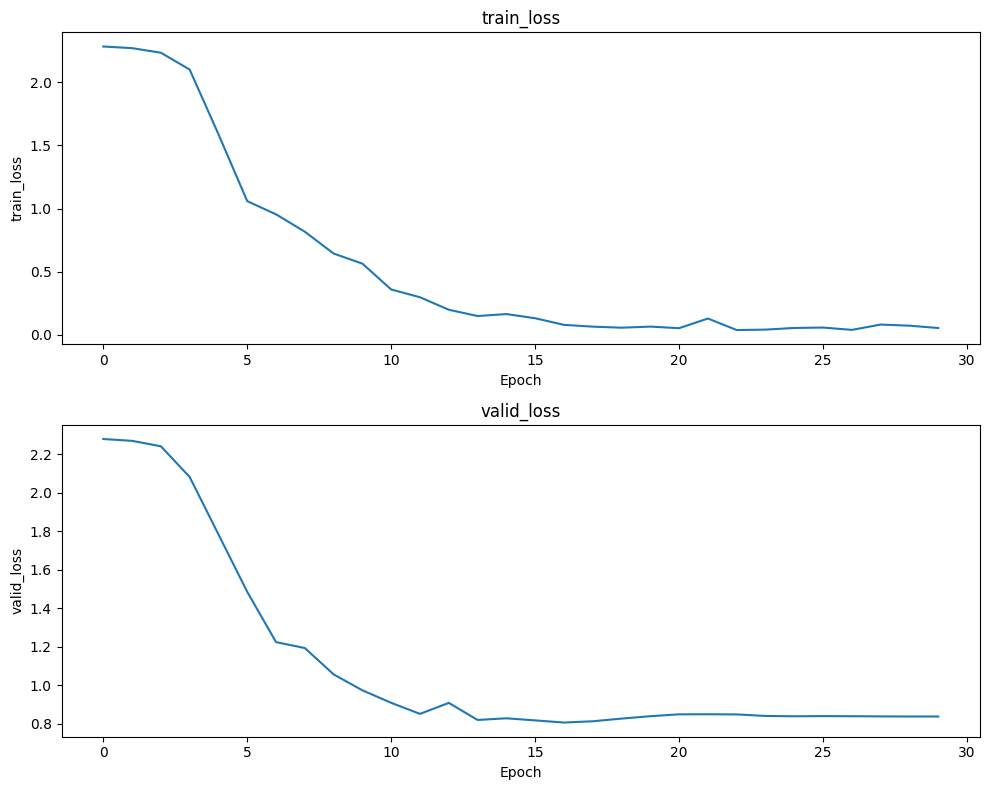

In [23]:
# Define the metrics to plot
metrics = list(history.keys())
print(f'Metrics: {metrics} \tHistory size: {len(history[metrics[0]])}')

# Plot each metric in a separate subplot
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 8))
for i, metric in enumerate(metrics):
    axs[i].plot(history[metric])
    axs[i].set_title(metric)
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel(metric)
plt.tight_layout()
plt.show()